In [54]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
df = pd.read_csv('data/preprocessed_case_study_data.csv')
#train, val = train_test_split(df, stratify = df.product_group, test_size = 0.1)
#with open('val_indices.pickle', 'wb') as f:
#    pickle.dump(np.array(val.complaint_id), f)

In [ ]:
with open('data/val_indices.pickle', 'rb') as f:
    val_ind = pickle.load(f)
with open('data/label_mapping.pickle', 'rb') as f:
    map_dct = pickle.load(f)

In [34]:
train = df.loc[~df.complaint_id.isin(val_ind)]
val = df.loc[df.complaint_id.isin(val_ind)]

In [27]:
vectorizer = TfidfVectorizer(max_features = 1000, ngram_range = (1, 2))
vectorizer.fit(train.prep_text.tolist())

In [28]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [31]:
#with open('models/tfidf_svm/tfidf_word_1000.pickle', 'wb') as f:
#    pickle.dump(vectorizer, f)

In [32]:
X_train = vectorizer.transform(train.prep_text.tolist())
X_val = vectorizer.transform(val.prep_text.tolist())


In [97]:
print(X_train.shape)
print(X_val.shape)

(241523, 1000)
(26836, 1000)


In [35]:
y_train  = np.array(train.label)
y_val = np.array(val.label)

In [36]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1,
                    n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0,power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
                    class_weight=None, warm_start=False, average=False)




In [39]:
clf.fit(X_train, y_train)
predictions_svm = clf.predict(X_val)

In [40]:
print("SVM linear: ")
print(classification_report(y_val, predictions_svm))

SVM linear: 
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      2007
           1       0.77      0.78      0.78      2955
           2       0.84      0.85      0.84      8123
           3       0.81      0.82      0.81      6146
           4       0.79      0.74      0.77      3104
           5       0.74      0.57      0.64       473
           6       0.91      0.92      0.91      4028

    accuracy                           0.82     26836
   macro avg       0.81      0.78      0.79     26836
weighted avg       0.82      0.82      0.82     26836



[[1592  183   72   42   26   47   45]
 [ 145 2302  250  160   52   28   18]
 [  47  222 6893  612  225    2  122]
 [  50  117  600 5056  197    4  122]
 [  58   96  256  313 2303   10   68]
 [ 113   38   18   16    9  268   11]
 [  31   25  123   63   92    3 3691]]


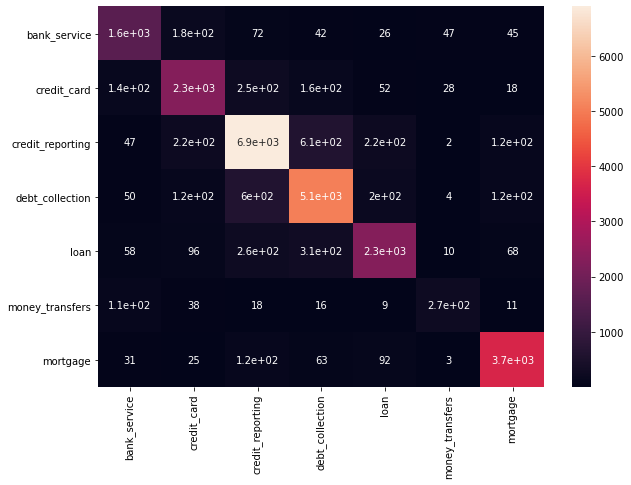

In [49]:
import seaborn as sn
cm = confusion_matrix(np.array(y_val), predictions_svm)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in map_dct.keys()],
                  columns = [i for i in map_dct.keys()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [51]:
#with open('models/sgd_base.pickle', 'wb') as f:
#    pickle.dump(clf, f)

# Cross Validation

In [62]:
# Set the parameters by cross-validation

cv = StratifiedKFold(5) 
tuned_parameters = {'random_state': [0],
                    'loss': ('log', 'hinge'),
                    'penalty': ['l1', 'l2', 'elasticnet'],
                    'alpha': [0.001, 0.0001, 0.00001, 0.000001]}


scores = ['precision', 'recall']



for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SGDClassifier(), tuned_parameters, scoring='%s_macro' % score, cv = cv, n_jobs = 12)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(X_val)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'alpha': 1e-05, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 0}

Grid scores on development set:

0.755 (+/-0.048) for {'alpha': 0.001, 'loss': 'log', 'penalty': 'l1', 'random_state': 0}
0.752 (+/-0.128) for {'alpha': 0.001, 'loss': 'log', 'penalty': 'l2', 'random_state': 0}
0.761 (+/-0.106) for {'alpha': 0.001, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 0}
0.691 (+/-0.010) for {'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l1', 'random_state': 0}
0.803 (+/-0.006) for {'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2', 'random_state': 0}
0.783 (+/-0.023) for {'alpha': 0.001, 'loss': 'hinge', 'penalty': 'elasticnet', 'random_state': 0}
0.796 (+/-0.008) for {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1', 'random_state': 0}
0.808 (+/-0.004) for {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2', 'random_state': 0}
0.805 (+/-0.006) for {'alpha': 0.0001, 'loss': 'log', 'penalty': '

ValueError: 'f1-score_macro' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [69]:
best_parameters = {'alpha': 1e-05, 'loss': 'hinge', 'penalty': 'l1', 'random_state': 0}

clf = SGDClassifier(**params)


In [70]:
clf.fit(X_train, y_train)
predictions_svm = clf.predict(X_val)
# Use accuracy_score function to get the accurac

In [88]:
print("SVM linear best: ")
print(classification_report(y_val, predictions_svm,  target_names = map_dct.keys()))

SVM linear best: 
                  precision    recall  f1-score   support

    bank_service       0.82      0.77      0.79      2007
     credit_card       0.77      0.79      0.78      2955
credit_reporting       0.86      0.84      0.85      8123
 debt_collection       0.81      0.83      0.82      6146
            loan       0.77      0.77      0.77      3104
 money_transfers       0.69      0.69      0.69       473
        mortgage       0.90      0.92      0.91      4028

        accuracy                           0.83     26836
       macro avg       0.80      0.80      0.80     26836
    weighted avg       0.83      0.83      0.83     26836



[[1537  191   66   47   32   79   55]
 [ 127 2329  206  164   65   41   23]
 [  34  254 6806  623  279    3  124]
 [  39  114  544 5082  235    8  124]
 [  34   88  217  286 2402   11   66]
 [  69   30    6   16   13  325   14]
 [  30   18  109   60   94    6 3711]]


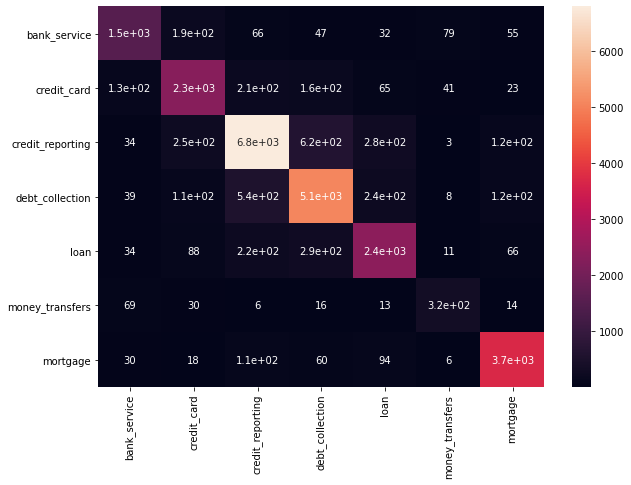

In [89]:
cm = confusion_matrix(y_val, predictions_svm)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in map_dct.keys()],
                  columns = [i for i in map_dct.keys()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [72]:
with open('models/sgd_best.pickle', 'wb') as f:
    pickle.dump(clf, f)